# Predicting Stock Market Prices Using a Recurrent Neural Network
> There is a common belief that market movements are predictable using a number of technical indicators and chart patterns. If such signals do exhibit these fortune-telling properties, they should be detectable by a deep learning neural network and exploitable. In this post, we will examine these possibilities by designing a recurrent neural network in keras-tensorflow and see just how much money we can make.


- toc: true
- branch: master
- author: Michael Hotaling
- badges: true
- comments: true
- categories: [jupyter, matplotlib,python, recurrent neural network, machine learning]
- hide: false
- image: images/stocks.jpeg
- show_image: true
- permalink: /stock_market_rnn/
- hide_binder_badge: false
- hide_colab_badge: false



In [1]:
#hide
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

# Collecting the Data
There are a few libraries that we can use for a project like this. One of them is yfinance, which pulls data from Yahoo Finance and, until recently, Google Finance as well. It seems like both Yahoo and Google aren't fans of their services being hijacked by these libraries though since yfinance breaks all the time due to system changes by Yahoo and Google. As of writing this blog, loading historical stock data via yfinance using Yahoo Finance is not working. 

Instead of relying on a library to pull our data, we can build our own function to pull data from Yahoo Finance using their historical data page. There is an option in Yahoo to download data as a CSV object, so all we need to do is build our URL and pass it into pandas to get our data

In [2]:
def load_historical_stock_data(ticker:str, 
                               start = "1900-01-01", 
                               end = datetime.today().strftime("%Y-%m-%d"), 
                               interval = '1d'):
               
    # Convert string time to datetime
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    
    # Calculate second since epoch
    start = int((start - datetime(1970,1,1)).total_seconds())
    end = int((end - datetime(1970,1,1)).total_seconds())
    
    # I like to format my urls like this, it feels cleaner
    # The new lines add which spaces, so that's what replace is for
    url = f"https://query1.finance.yahoo.com/v7/finance/download/\
            {ticker}?\
            period1={start}&\
            period2={end}&\
            interval={interval}&\
            events=history&\
            includeAdjustedClose=true".replace(" ","")
    

    return (pd.read_csv(url)
            .astype({'Date':'datetime64'})
            .set_index('Date')
           )

Now we can generate our data with a simple query. 

In [4]:
ticker = "SPY"
df = load_historical_stock_data(ticker)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-22,436.910004,438.079987,425.440002,426.040009,426.040009,132354400
2022-04-25,423.670013,428.690002,418.839996,428.510010,428.510010,119647700
2022-04-26,425.829987,426.040009,416.070007,416.100006,416.100006,103996300
2022-04-27,417.239990,422.920013,415.010010,417.269989,417.269989,122030000
2022-04-28,422.290009,429.640015,417.600006,427.809998,427.809998,103414700


We also might want to pull a list of stocks with a single query. This can be done using the same function and iterating over a list of stocks.

In [5]:
def load_multistock_data(stocks:list, 
                         start = "1900-01-01", 
                         end = datetime.today().strftime("%Y-%m-%d"), 
                         interval = '1d'):
    
    df = pd.DataFrame(columns=stocks, index=pd.to_datetime([]))
    for stock in stocks:
        stock_df = load_historical_stock_data(stock, start, end, interval)
        if len(stock_df) > len(df):
            df = df.reindex(stock_df.index)
        df[stock] = stock_df['Adj Close']
    return df

In [6]:
stocks = ['TSLA','TM','F','GM','HMC']

df_m = load_multistock_data(stocks)

In [8]:
df_m.tail(10)

,TSLA,TM,F,GM,HMC
Date,,,,,
2022-04-14,985.000000,167.259995,15.377687,40.130001,25.750000
2022-04-18,1004.289978,170.270004,15.566431,40.630001,25.910000
2022-04-19,1028.150024,171.449997,16.043259,42.080002,26.219999
2022-04-20,977.200012,175.449997,15.943918,41.720001,26.760000
2022-04-21,1008.780029,173.669998,15.596232,40.709999,26.450001
2022-04-22,1005.049988,169.529999,15.030000,39.840000,25.930000
2022-04-25,998.020020,172.160004,15.190000,39.820000,26.459999
2022-04-26,876.419983,166.820007,14.710000,38.040001,25.830000
2022-04-27,881.510010,168.039993,14.850000,38.660000,25.690001


# Data Visualizations
It's always fun to generate plots with our data. It's a great way to find patterns, missing values, and other anomalies we might not expect. Since stock prices are constantly changing minute-to-minute, the data is typically plotted in candle-stick notation.  The open and close prices are shown as the height of the candle and the color notates the direction of the stocks movement. There aren't any great libraries to generate these plots either, so we can summarize our data by grouping it and using our function below to plot our candlestick chart.

In [9]:
def candle_plotter(df):
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Generate a psuedo plot for overlay
    ax.plot(df.index, df.Close, alpha = 0)
    
    start, end = ax.get_xlim()
    spacing = ((end-start)/len(df))/2
    
    for ind, row in df.iterrows():
        color = 'green'
        if row['Close'] < row['Open']:
            color = 'red'
        ind = mdates.date2num(ind)
        rect = patches.Rectangle((ind, row['Open']), 
                                 spacing,
                                 row['Close']-row['Open'], 
                                 linewidth=1, 
                                 edgecolor=color, 
                                 facecolor=color,
                                 fill=True)
        
        ax.add_patch(rect)
    ax.yaxis.set_major_formatter('${x:1.2f}')

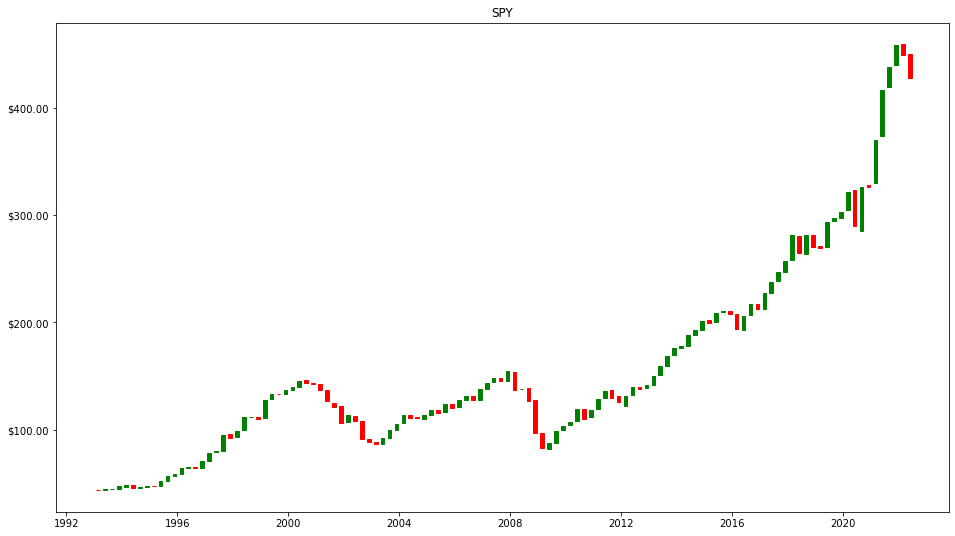

In [10]:
(df
 .groupby(pd.Grouper(freq = '3M'))
 .agg(Open = ('Open','first'), 
    High = ('High','max'), 
    Low = ('Low','min'), 
    Close = ('Close','last'))
 .tail(4*3*100)
 .pipe(lambda x: candle_plotter(x))
 )

#plt.grid(True)
plt.title(ticker)
plt.show()

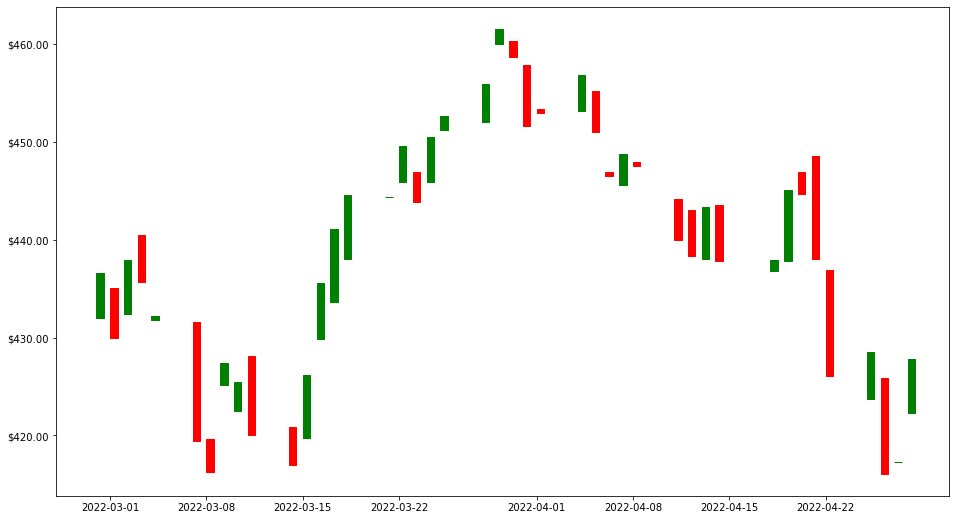

In [15]:
(df
 .groupby(pd.Grouper(freq = 'd'))
 .agg(Open = ('Open','first'), 
      High = ('High','max'), 
      Low = ('Low','min'), 
      Close = ('Close','last'))
 .tail(60)
 .pipe(lambda x: candle_plotter(x))
)

Using the candlestick plotter for a dataframe with multiple stocks would be tricky since the candles would be overlapping. We will have to settle with a simple lineplot when plotting multiple stocks.

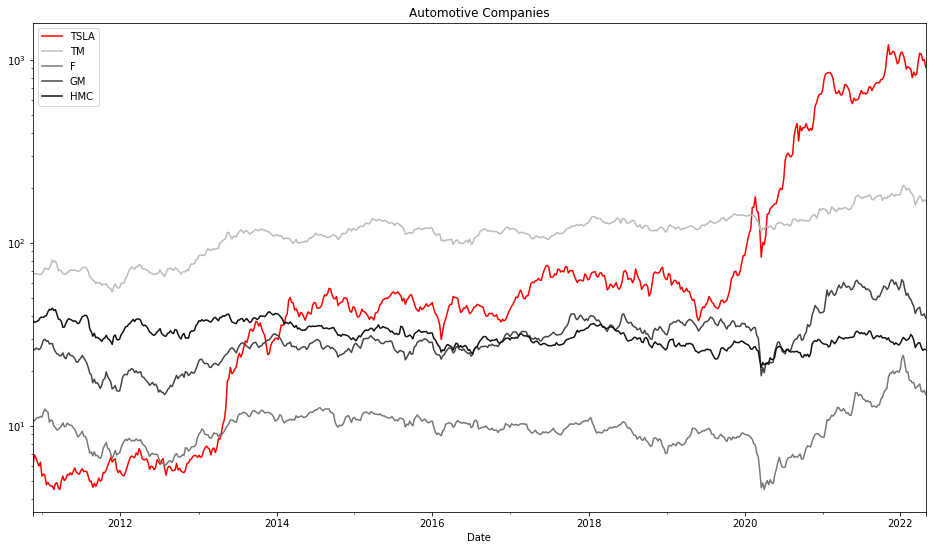

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
(df_m
 .dropna()
 .groupby(pd.Grouper(freq = 'w'))
 .mean()
 .plot(logy=True, 
       ax = ax, color = ['red',
                         '#bbbbbb',
                         '#777777',
                         '#444444',
                         '#111111'])
)
plt.title("Automotive Companies")
plt.show()

# Feature Engineering

## Moving Averages
### Simple Weighted Moving Average
### Exponentially Weighted Moving Average

## MACD

## RSI